In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [2]:
import tensorflow as tf
tf.random.set_seed(123)

In [3]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name, vocab)
    )

feature_columns= []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [4]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs = None, shuffle = True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = (dataset
                  .repeat(n_epochs)
                  .batch(NUM_EXAMPLES))
        return dataset
    return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
        

In [5]:
params = {
    'n_trees': 50, 
    'max_depth': 3,
    'n_batches_per_layer': 1,
    'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
est.train(train_input_fn, max_steps=100)

results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.868595
auc_precision_recall,0.850457
average_loss,0.418110
label/mean,0.375000
loss,0.418110
precision,0.752688
prediction/mean,0.386081
recall,0.707071


In [6]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1

def make_inmemory_train_input_fn(X,y):
    y = np.expand_dims(y, axis=1)
    def input_fn():
        return dict(X), y
    return input_fn

train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    train_in_memory=True,
    **in_memory_params
)

est.train(train_input_fn)

result = est.evaluate(eval_input_fn)
clear_output()
pd.Series(result).to_frame()

,0
accuracy,0.814394
accuracy_baseline,0.625000
auc,0.869268
auc_precision_recall,0.852874
average_loss,0.414408
label/mean,0.375000
loss,0.414408
precision,0.760417
prediction/mean,0.388469
recall,0.737374


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [8]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\June\\AppData\\Local\\Temp\\tmplkldv4iw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorf

In [9]:
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.026201,0.093400,-0.147969,-0.076613,-0.054171,0.003090,0.505813
sex,264.0,0.006555,0.107802,-0.097792,-0.074628,-0.072858,0.138226,0.182456
class,264.0,0.017197,0.093079,-0.133776,-0.043060,-0.041724,0.033055,0.231730
deck,264.0,-0.018092,0.032576,-0.094638,-0.042912,-0.032754,0.001897,0.199893
embark_town,264.0,-0.007019,0.031440,-0.056042,-0.017526,-0.015517,-0.003948,0.086491
fare,264.0,0.027099,0.089148,-0.224306,-0.028055,-0.002334,0.072627,0.285098
n_siblings_spouses,264.0,0.001351,0.026091,-0.133110,0.002419,0.003337,0.006167,0.103482
parch,264.0,0.000020,0.011432,-0.098722,0.000654,0.000864,0.001482,0.040270
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
# Sum of DFCs + bias == probability
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [11]:
def _get_color(value):
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha = 0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
                fontproperties = font, size=12)
    
def plot_example(example):
    TOP_N = 8
    sorted_ix = example.abs().sort_values()[-TOP_N:].index
    example = example[sorted_ix]
    colors = example.map(_get_color).to_list()
    ax = example.to_frame().plot(kind='barh',
                                color = [colors],
                                legend=None,
                                alpha = 0.75,
                                figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)
    
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

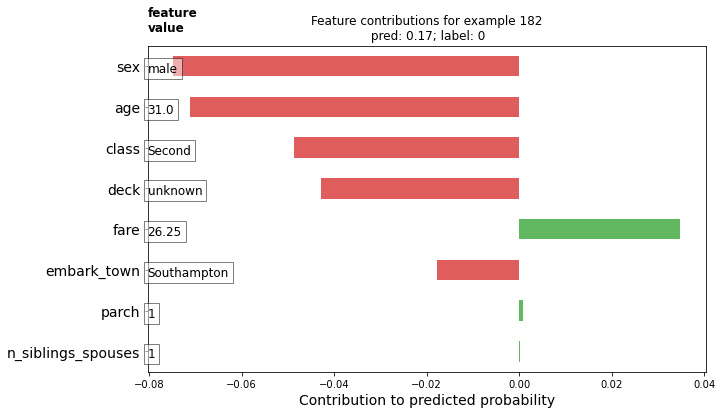

In [12]:
ID=182
example = df_dfc.iloc[ID]
TOP_N = 8
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [13]:
def dist_violin_plot(df_dfc, ID):
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    
    TOP_N = 8
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')
    
    parts = ax.violinplot([df_dfc[w] for w in ix],
                         vert = False,
                         showextrema = False,
                         widths=0.7,
                         positions = np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)
        
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    
    ax.scatter(example,
              np.arange(example.shape[0]),
              color = sns.color_palette()[2],
              s=100,
              marker="s",
              label = 'contributions for example')
    
    ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
           color = face_color, alpha = alpha, linewidth=10)
    legend = ax.legend(loc='lower right', shadow=True, fontsize = 'x-large',
                      frameon=True)
    legend.get_frame().set_facecolor('white')
    
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

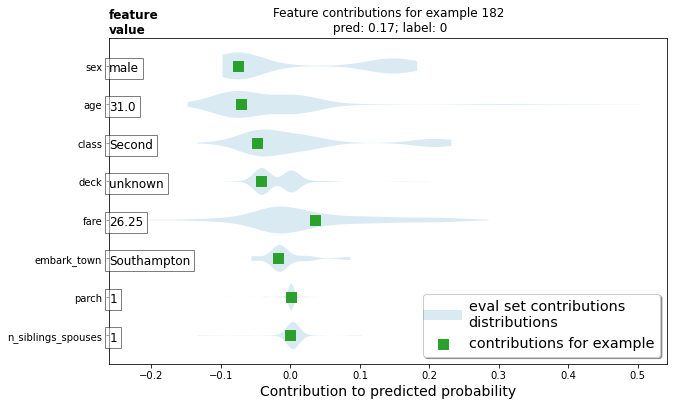

In [14]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

In [15]:
df_dfc.iloc[ID].abs().sort_values()[-8:]

n_siblings_spouses    0.000107
parch                 0.000801
embark_town           0.017793
fare                  0.034820
deck                  0.042893
class                 0.048776
age                   0.071202
sex                   0.074855
Name: 182, dtype: float64

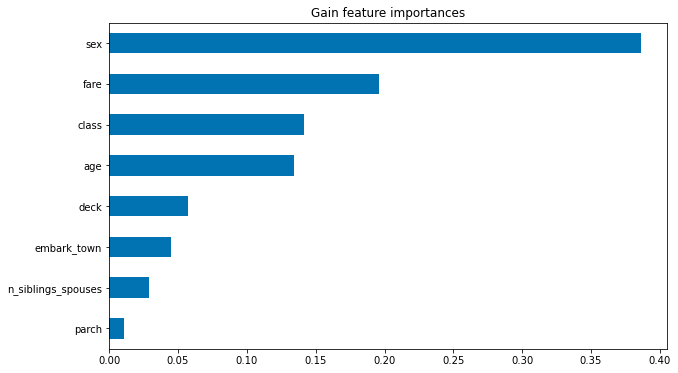

In [16]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

N=8
ax = (df_imp.iloc[0:N][::-1]
     .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10,6)))
ax.grid(False, axis='y')

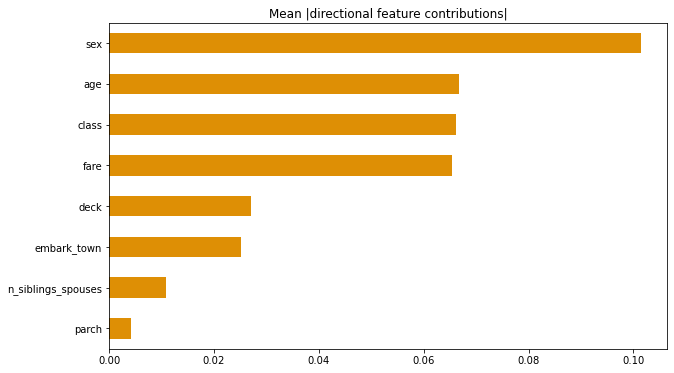

In [17]:
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index
ax = dfc_mean[sorted_ix].plot(kind='barh',
                             color=sns_colors[1],
                             title='Mean |directional feature contributions|',
                             figsize=(10,6))
ax.grid(False, axis='y')

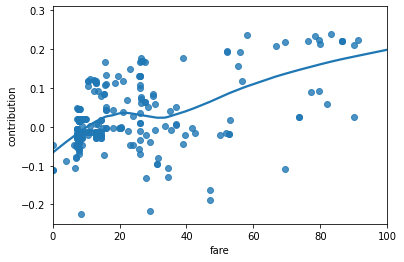

In [18]:
FEATURE='fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0,100)
plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-19T02:13:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\June\AppData\Local\Temp\tmplkldv4iw\model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.23627s
INFO:tensorflow:Finished evaluation at 2020-12-19-02:13:25
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.81439394, accuracy_baseline = 0.625, auc = 0.8692684, auc_precision_recall = 0.8528743, average_loss = 0.4144078, global_step = 153, label/mean = 0.375, loss = 0.4144078, precision = 0.7604167, prediction/mean = 0.3884691, recall = 0.7373737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: C:\Users\June\AppData\Local\Temp\tmplkldv4iw\model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation a

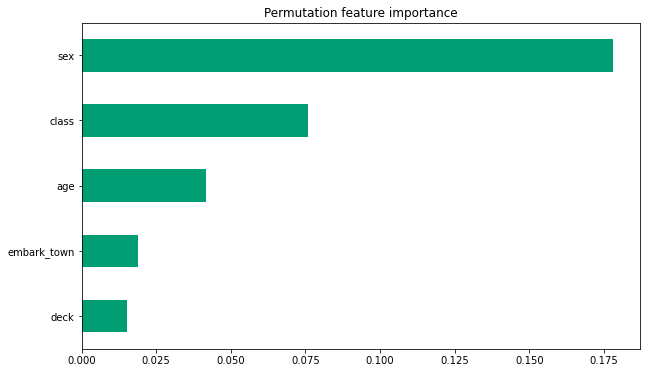

In [21]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m =metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    eval_input_fn = make_input_fn(X, y=y, shuffle=False, n_epochs=1)
    return est.evaluate(input_fn = eval_input_fn)['accuracy']


features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric, features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10,6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

In [23]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
xy = np.zeros((2, np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [45]:
df = pd.DataFrame({'x':x, 'y':y, 'z':z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [55]:
def plot_contour(x,y,z, **kwargs):
    plt.figure(figsize=(10,8))
    CS = plt.contour(x,y,z, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(x,y,z, 15, vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
    plt.colorbar()
    plt.xlim(-2,2)
    plt.ylim(-2,2)

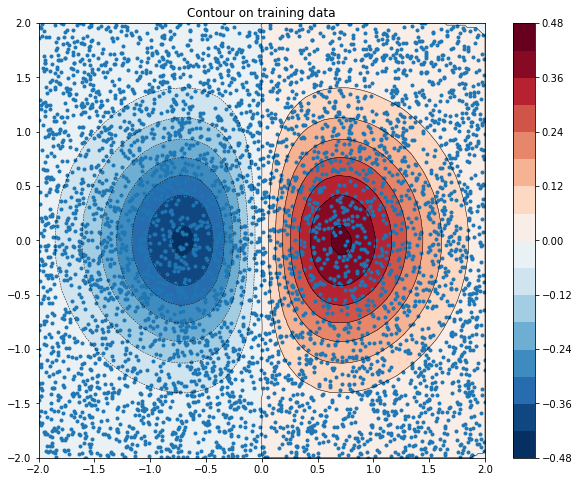

In [54]:
zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi,yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [56]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [57]:
def predict(est):
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

In [58]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps = 500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\June\\AppData\\Local\\Temp\\tmpr8mgk35w', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


c:\workspace\python\project1\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\June\AppData\Local\Temp\tmpr8mgk35w\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.023884524, step = 0
INFO:tensorflow:global_step/sec: 191.048
INFO:tensorflow:loss = 0.016542595, step = 100 (0.522 sec)
INFO:tensorflow:global_step/sec: 241.149
INFO:tensorflow:loss = 0.019593094, step = 200 (0.415 sec)
INFO:tensorflow:global_step/sec: 225.748
INFO:tensorflow:loss = 0.018450243, step = 300 (0.443 sec)
INFO:tensorflow:global_step/sec: 204.354
INFO:tensorflow:loss = 0.018470977, step 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\June\AppData\Local\Temp\tmpr8mgk35w\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


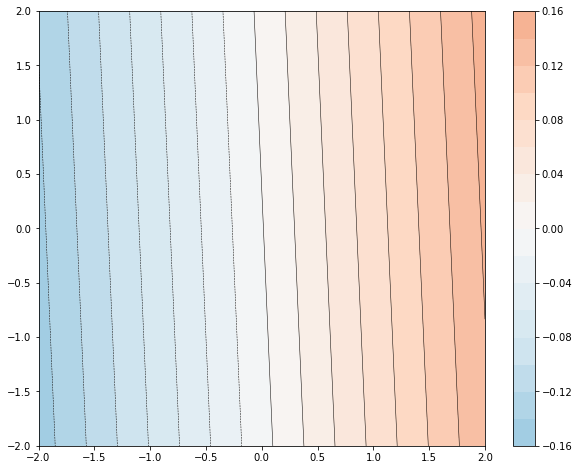

In [59]:
plot_contour(xi, yi, predict(est))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\June\AppData\Local\Temp\tmpj4akt3jd\model.ckpt-222
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


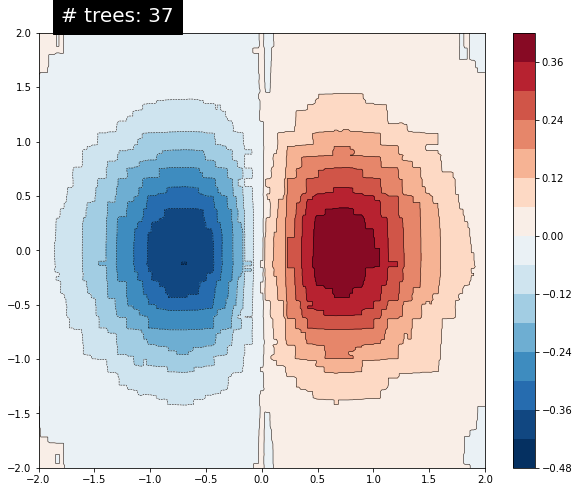

In [61]:
n_trees = 37

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi,yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()